<a href="https://colab.research.google.com/github/soujanyakd/Project_CNN_RNN/blob/main/UNSW_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive. mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
pip install -q keras


In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer


import pydot

In [ ]:

#uploading training dataset
train_data= pd.read_csv("/content/drive/MyDrive/UNSW_NB15_training-set.csv")
print('-------Train data--------')
print(train_data['attack_cat'].value_counts())
print(len(train_data))
print('-------------------------')

-------Train data--------
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64
82332
-------------------------


In [ ]:
#uploading testing dataset 
test_data= pd.read_csv("/content/drive/MyDrive/UNSW_NB15_testing-set.csv")
print('-------Test data--------')
print(test_data['attack_cat'].value_counts())
print(len(test_data))
print('-------------------------')
test_data.shape

-------Test data--------
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64
175341
-------------------------


(175341, 45)

Train data length 82332
-------------------------
Test data length 175341
-------------------------


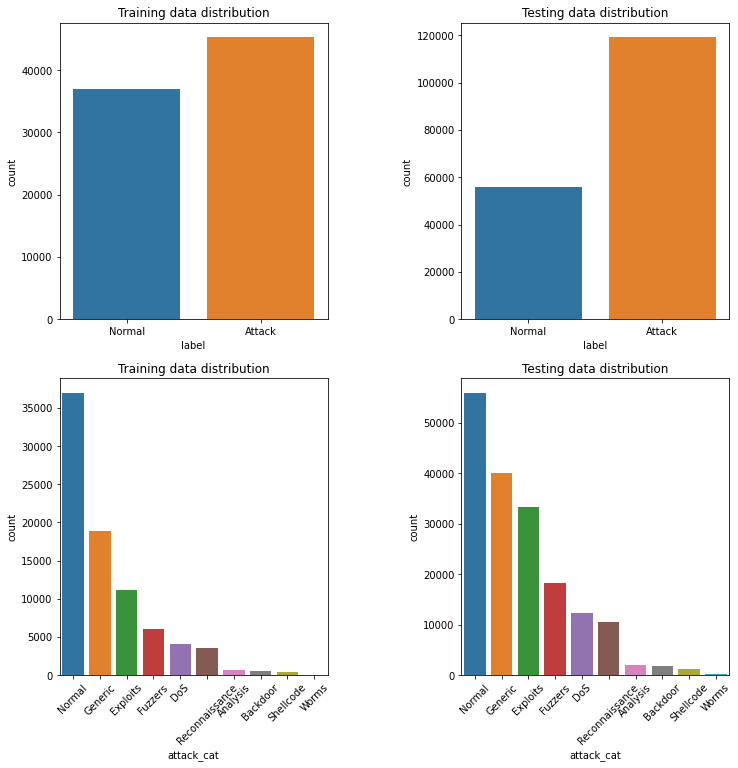

In [ ]:
#represent data in form of bar graph
print("Train data length",len(train_data))
print('-------------------------')
print("Test data length",len(test_data))
print('-------------------------')

#distribution of attacks and normal traffic
f, axes = plt.subplots(2, 2, figsize=(12, 12))

# Create the plots using seaborn package
sns.countplot(x="label", data=train_data, ax=axes[0,0])
sns.countplot(x="label", data=test_data, ax=axes[0,1])
sns.countplot(x="attack_cat", data=train_data, ax=axes[1,0], order = train_data['attack_cat'].value_counts().index)
sns.countplot(x="attack_cat", data=test_data, ax=axes[1,1], order = test_data['attack_cat'].value_counts().index)

# plot titles
axes[0,0].set_title("Training data distribution")
axes[1,0].set_title("Training data distribution")
axes[0,1].set_title("Testing data distribution")
axes[1,1].set_title("Testing data distribution")

# Rotate xticks for readability
axes[1,0].tick_params('x', labelrotation=45)
axes[1,1].tick_params('x', labelrotation=45)

# Change the xtick labels for attack / normal
axes[0,0].set_xticklabels(["Normal", "Attack"])
axes[0,1].set_xticklabels(["Normal", "Attack"])

# Adding some space between the plots for y labels
plt.subplots_adjust(wspace=0.5)

In [ ]:
#Dataset observation for training data
train_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
#RangeIndex: 82332 entries, 0 to 82331  
#Data columns (total 45 columns):
train_data.shape


(82332, 45)

In [ ]:
#Dataset observation for testing data
test_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
#RangeIndex: 175341 entries, 0 to 175340
#Data columns (total 45 columns):
test_data.shape

(175341, 45)

In [ ]:
#preprocessing
#Evaluation of the training dataset
train_data.isnull().sum()
#train_data.isnull()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [ ]:
#Evaluation of the training dataset
print(all(((train_data.label == 1) & (train_data.attack_cat != 'Normal')) == (train_data.attack_cat != 'Normal')))
print('--------')
print(all(((train_data.attack_cat != 'Normal') & (train_data.label == 1)) == (train_data.label == 1)))


True
--------
True


In [ ]:
#attacks
mask = (train_data.label == 1)
print(train_data.loc[mask,:].service.value_counts())
print(train_data.loc[mask,:].proto.value_counts())

-           19778
dns         18299
http         4274
smtp         1216
ftp           794
ftp-data      447
pop3          423
ssl            30
snmp           29
dhcp           26
radius          7
irc             5
ssh             4
Name: service, dtype: int64
udp            21321
tcp            15247
unas            3515
ospf             638
sctp             324
               ...  
fc                32
uti               32
srp               32
compaq-peer       32
ib                31
Name: proto, Length: 129, dtype: int64


In [ ]:
#normal
mask = (train_data.label == 0)
print(train_data.loc[mask,:].service.value_counts())
print(train_data.loc[mask,:].proto.value_counts())

-           27375
http         4013
dns          3068
ftp-data      949
ftp           758
smtp          635
ssh           200
radius          2
Name: service, dtype: int64
tcp     27848
udp      8097
arp       987
ospf       38
igmp       30
Name: proto, dtype: int64


In [ ]:
num_words = 60000

tokenizer = Tokenizer(num_words=num_words,oov_token="unclear")
tokenizer.fit_on_texts(train_data['attack_cat'].tolist())


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['attack_cat'].tolist(),\
                                                      train_data['attack_cat'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['attack_cat'].tolist(),\
                                                      random_state=0)
print('Train data length:\n'+str(len(X_train)))
print('Class distribution '+str(Counter(y_train)))
print('Valid data len:\n'+str(len(X_valid)))
print('Class distribution '+ str(Counter(y_valid)))

Train data length:
65865
Class distribution Counter({'Normal': 29600, 'Generic': 15097, 'Exploits': 8905, 'Fuzzers': 4850, 'DoS': 3271, 'Reconnaissance': 2797, 'Analysis': 542, 'Backdoor': 466, 'Shellcode': 302, 'Worms': 35})
Valid data len:
16467
Class distribution Counter({'Normal': 7400, 'Generic': 3774, 'Exploits': 2227, 'Fuzzers': 1212, 'DoS': 818, 'Reconnaissance': 699, 'Analysis': 135, 'Backdoor': 117, 'Shellcode': 76, 'Worms': 9})


In [ ]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['attack_cat'].tolist()) )

x_train = pad_sequences(x_train, padding='post', maxlen=20)
x_valid = pad_sequences(x_valid, padding='post', maxlen=20)
x_test = pad_sequences(x_test, padding='post', maxlen=20)

print(x_train[1])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['attack_cat'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
le = LabelEncoder()
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['Generic', 'Normal', 'Normal', 'Exploits', 'Exploits', 'Reconnaissance', 'Exploits', 'DoS', 'Fuzzers', 'Generic']
Text to number
[5 6 6 3 3 7 3 2 4 5]
Number to category
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [ ]:
count =0
print('--------Train dataset -------')
for value,label in train_ds:
  if count==3:
    break
  else:
    count += 1
    print(value,label)
    
count =0
print('-------Validation dataset -------')
for value,label in valid_ds:
  if count==3:
    break
  else:
    count += 1
    print(value,label)
print('-------Test dataset -------')
for value,label in test_ds:
  if count==3:
    break
  else:
    count += 1
print(value,label)

--------Train dataset -------
tf.Tensor([3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int32) tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int32) tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int32) tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
-------Validation dataset -------
tf.Tensor([2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int32) tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int32) tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int32) tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
-------Test dataset -------
tf.Tenso

In [ ]:
#CNN model

max_features =20000
embedding_dim = 64
sequence_length = 45

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,10, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(10, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 64)            1280064   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 128)           82048     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 1,363,402
Trainable params: 1,363,402
Non-trainable params: 0
_________________________________________________________________


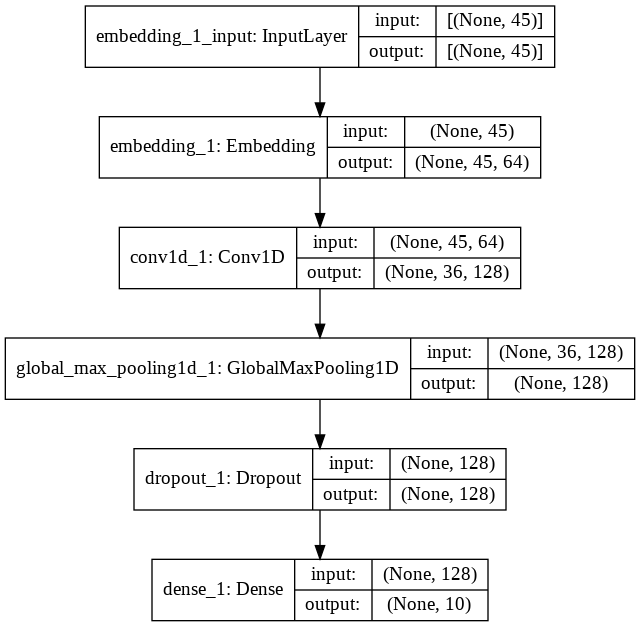

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
epochs = 10
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs=epochs,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


515/515 [==============================] - 23s 44ms/step - loss: 0.4295 - categorical_accuracy: 0.9012 - val_loss: 0.0935 - val_categorical_accuracy: 0.9948
Epoch 2/10
515/515 [==============================] - 22s 43ms/step - loss: 0.0920 - categorical_accuracy: 0.9974 - val_loss: 0.0741 - val_categorical_accuracy: 0.9995
Epoch 3/10
515/515 [==============================] - 22s 43ms/step - loss: 0.0804 - categorical_accuracy: 0.9991 - val_loss: 0.0690 - val_categorical_accuracy: 0.9995
Epoch 4/10
515/515 [==============================] - 22s 43ms/step - loss: 0.0766 - categorical_accuracy: 0.9993 - val_loss: 0.0671 - val_categorical_accuracy: 0.9995
Epoch 5/10
515/515 [==============================] - 22s 43ms/step - loss: 0.0743 - categorical_accuracy: 0.9994 - val_loss: 0.0666 - val_categorical_accuracy: 0.9995
Epoch 6/10
515/515 [==============================] - 22s 43ms/step - loss: 0.0736 - categorical_accuracy: 0.9994 - val_loss: 0.0657 - val_categorical_accuracy: 0.9995
Epo

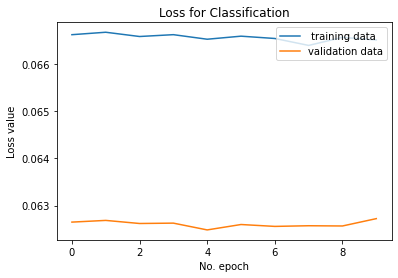

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

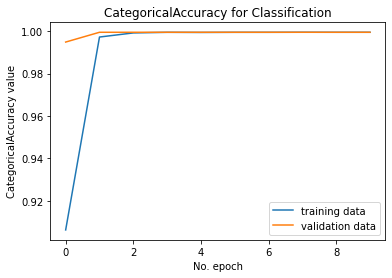

In [ ]:
plt.plot(history.history['categorical_accuracy'], label='training data')
plt.plot(history.history['val_categorical_accuracy'], label='validation data')
plt.title('CategoricalAccuracy for Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

In [ ]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['attack_cat'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=45)

In [ ]:
predictions = model.predict(x_test)
predict_results = predictions.argmax(axis=1)

[[0.5107332  0.24879098 0.31568366 ... 0.29265106 0.1783661  0.25574636]
 [0.5107332  0.24879098 0.31568366 ... 0.29265106 0.1783661  0.25574636]
 [0.5107332  0.24879098 0.31568366 ... 0.29265106 0.1783661  0.25574636]
 ...
 [0.01373363 0.41135213 0.25903672 ... 0.3364569  0.61968625 0.30728182]
 [0.01373363 0.41135213 0.25903672 ... 0.3364569  0.61968625 0.30728182]
 [0.01373363 0.41135216 0.25903678 ... 0.33645684 0.61968637 0.3072818 ]]


In [ ]:
test_data['detect_attack']= predict_results
test_data['detect_attack'] = np.where((test_data.detect_attack == '6'),'Normal',test_data.detect_attack)
test_data['detect_attack'] = np.where((test_data.detect_attack == '0'),'Analysis',test_data.detect_attack)
test_data['detect_attack'] = np.where((test_data.detect_attack == '3'),'Exploits',test_data.detect_attack)
test_data['detect_attack'] = np.where((test_data.detect_attack == '7'),'Reconnaissance',test_data.detect_attack)

In [ ]:
labels = ['Normal', 'Analysis','Exploits','Reconnaissance']
    
print(classification_report(test_data['attack_cat'].tolist(),test_data['detect_attack'].tolist(),labels=labels))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

        Normal       0.00      0.00      0.00     56000
      Analysis       0.94      1.00      0.97      2000
      Exploits       1.00      1.00      1.00     33393
Reconnaissance       1.00      1.00      1.00     10491

     micro avg       1.00      0.45      0.62    101884
     macro avg       0.73      0.75      0.74    101884
  weighted avg       0.45      0.45      0.45    101884

